# Project: Image classification with Resnet-34

**Project name:** Image classification with Resnet-34. <br>
Autor: Tomasz Ostaszewicz <br>
Implementation: pandas, matplotlib, mainly in **pytorch**.

**Description:** This project is aimed to classify MNIST data set with Resnet-34 architecture. This is multi-classifcation problem with 10 classees (digits from 0 to 9). Train and test sets are selected acording to Kaggle competition: [https://www.kaggle.com/c/digit-recognizer](https://www.kaggle.com/c/digit-recognizer).
    
Conclusions of analysis are presented below.

In [1]:
import torch
import torch.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import pandas as pd
import pdb
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from IPython.display import display
from PIL import Image
import time
import datetime

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


# 1. Reading and visualising data

Let's define basic constants used during training.

In [2]:
IMAGE_SIZE_AFTER_RESIZE = 64 # Original images have shape (28, 28). During training are upscaled to given below value that is to (64, 64). This is done to manatin original architecture of Resnet-34 without modifications (except of output layer).
NB_OF_CLASSES = 10 # Number of output classes
BS_TRAIN = 4 # Batch size for training data. Low batch size is to assure randomens in training process and thus low generalization error
BS_VALID = 8 * 1024 # Batch size for validation data. This is limited by memory of graphics cards. Higher batch size if it fits into GPU memory means lower computation time.

Device to execute model forward pass and gradient computations.

In [3]:
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

Paths for input and output folders. Input data is downloaded from Kaggle competition: [https://www.kaggle.com/c/digit-recognizer/data](https://www.kaggle.com/c/digit-recognizer/data)

In [4]:
PATH_INPUT = Path('~/mnist/mnist/input')
PATH_OUTPUT = Path('~/mnist/mnist/output')
df_train = pd.read_csv(PATH_INPUT/"train.csv")
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_test = pd.read_csv(PATH_INPUT/"test.csv")
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create numpy array from pixel values.

In [6]:
data_tensor = torch.tensor(df_train.loc[:,'pixel0':'pixel783'].values, dtype=torch.float32).reshape(df_train.shape[0], 28, 28) / 255
data_tensor.shape # This is training data

torch.Size([42000, 28, 28])

Lets see what is training data looks like (without data augmenation).

In [7]:
def show_random_sample(data_tensor, nb_rows, nb_cols):
    
    rand_idx = np.random.randint(0, data_tensor.shape[0], size = nb_rows * nb_cols)
    fig, ax = plt.subplots(nb_rows, nb_cols, figsize = (nb_cols * 3, nb_rows * 3))

    for i, ax_i in enumerate(ax.flatten()):
        idx = rand_idx[i]
        ax_i.imshow(data_tensor[idx], cmap='gray_r')
        ax_i.set_title(f"True: {df_train.loc[idx, 'label']}")

    fig.tight_layout()

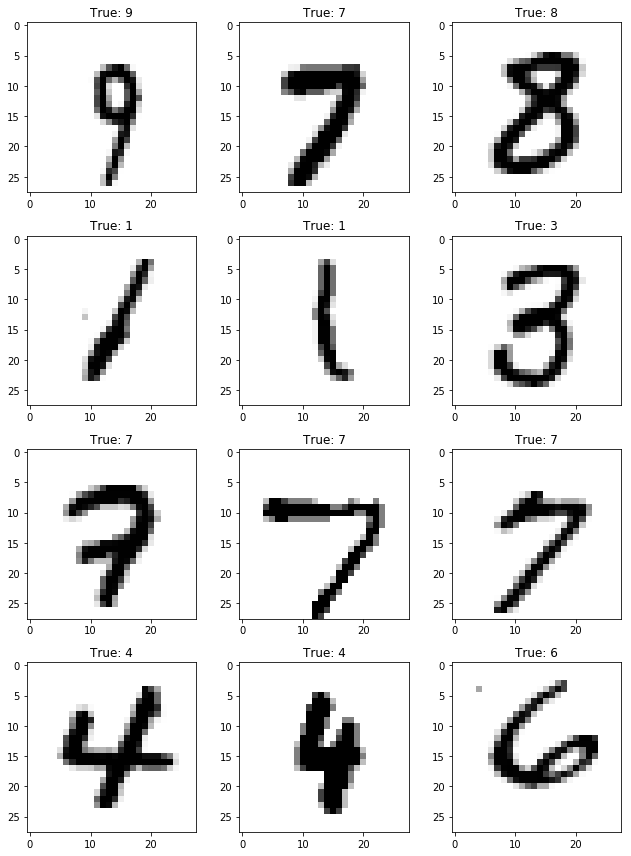

In [8]:
nb_rows = 4
nb_cols = 3

show_random_sample(data_tensor, nb_rows, nb_cols)

# 2. Definition of learning classes and functions 

This secction contains definition of classes used in model training: dataset, data bunch, convolution learning, functions for interpreting model results.

In [9]:
class DataMnistExpanded(torch.utils.data.Dataset):
    ''' Class defining dataset according Pytorch requirements '''
    
    def __init__(self, data_x, data_y, device, trms = None):
        
        # image transormation in Pytorch is done on cpu, after transforms tensors are moved to GPU memory
        self.data_x = data_x.cpu()
        self.data_y = data_y.cpu() if data_y is not None else None
        self.trms = trms
        self.output_device = device
        
    def __len__(self):
        return len(self.data_x)
    
    def __getitem__(self, i):
        
        x = self.data_x[i]
        x = x.expand(3, -1, -1)
        if self.trms is not None:
            x = self.trms(x)
            
        if self.data_y is not None:
            y = self.data_y[i]
        else:
            y = torch.tensor([])
            
        x = x.to(self.output_device)
        y = y.to(self.output_device)
            
        return x, y

In [10]:
class DataBunch:
    '''Class defining collection of datasets (training, validation and train)'''
    
    def __init__(self, df_train_valid, df_test, train_trms, test_trms, device, val_ds_pct = 0.2, dl_batch_size_train=4, dl_batch_size_valid=8*1024, dl_num_workers = 0):

        x_trainvalid_raw = self._convert_df_to_tensor_x(df_train_valid)
        y_trainvalid_raw = self._convert_df_to_tensor_y(df_train_valid)
        
        x_test_raw = self._convert_df_to_tensor_x(df_test)
        
        # Get indexes for the train and validation data sets
        self.idx_train, self.idx_valid = self.get_train_val_idx(x_trainvalid_raw.shape[0], val_ds_pct)
        
        # Create data sets
        self.ds_train = DataMnistExpanded(x_trainvalid_raw[self.idx_train], y_trainvalid_raw[self.idx_train], device, train_trms)
        self.ds_valid = DataMnistExpanded(x_trainvalid_raw[self.idx_valid], y_trainvalid_raw[self.idx_valid], device, test_trms)
        
        self.ds_test = DataMnistExpanded(x_test_raw, None, device, test_trms)
        
        # Create data loaders
        self.dl_train = torch.utils.data.DataLoader(self.ds_train, batch_size = dl_batch_size_train, num_workers = dl_num_workers, shuffle = True)
        self.dl_valid = torch.utils.data.DataLoader(self.ds_valid, batch_size = dl_batch_size_valid, num_workers = dl_num_workers)
        
        self.dl_test = torch.utils.data.DataLoader(self.ds_test, batch_size = dl_batch_size_valid, num_workers = dl_num_workers, shuffle = False)
    
    def _convert_df_to_tensor_x(self, data):
        'Helper function to read data from data frame to tensor'
        data_tensor = torch.tensor(data.loc[:,'pixel0':'pixel783'].values, dtype=torch.float32).reshape(data.shape[0], 28, 28) / 255
        return data_tensor
    
    def _convert_df_to_tensor_y(self, data):
        return torch.tensor(data['label'].values)
    
    def get_train_val_idx(self, size, val_ds_pct):
        
        idx_permuted = torch.randperm(size)
        first_train = int(val_ds_pct * size)
        idx_train = idx_permuted[first_train:]
        idx_valid = idx_permuted[:first_train]
        
        return idx_train, idx_valid
    
    def get_image(self, i, ds_type = 'train'):
        ''' Return image (usually for plotting) from given dataset.
            Is is assumed that tensors is data sets are normalized to ImageNet stats, so denormalization is applied
        '''
        
        if ds_type == 'valid':
            ds = self.ds_valid
        elif ds_type == 'test':
            ds = self.ds_test
        else:
            ds = self.ds_train
            
        # Reverse normalization
        im = transforms.functional.normalize(ds[i][0].cpu(), -np.array([0.485, 0.456, 0.406])/np.array([0.229, 0.224, 0.225]), 1/np.array([0.229, 0.224, 0.225]))
              
        return im.transpose(0,1).transpose(1,2)

The subsection below presents in visual results of data augmentation. What is interesting that complex transformation give worse generalization error than simple transformations. In final model training simple transformations are used. Function defined above is very useful in visual assessment of data augmenation.

In [11]:
def show_transf_effect(num_img, df_train, df_test, basic_transf, complex_transf, device, seed = 1):
    'Helper function to test effect of transformations'
    
    # Get transformed images
    torch.manual_seed(seed)
    db_standard_trms =  DataBunch(df_train, df_test, basic_transf, basic_transf, device)
    # Apply seed twice to get the same split for input data frame
    torch.manual_seed(seed)
    db_complex_trms = DataBunch(df_train, df_test, complex_transf, complex_transf, device)
    
    # Create figure and axes objects
    fig, ax = plt.subplots(num_img, 3, figsize= (8, 3 * num_img))
    
    # Get random indexes for images to draw (indexes for DataBunch object's property ds_train)
    rand_idx = np.random.randint(0, len(db_standard_trms.idx_train), size=num_img)
    
    for row_id in range(num_img):

        true_value = db_standard_trms.ds_train[rand_idx[row_id]][1].item()

         # Get original image from input data
        img_basic = df_train.loc[db_standard_trms.idx_train[rand_idx[row_id]].item(),'pixel0':'pixel783'].values.reshape(28, 28) / 255
        ax[row_id, 0].imshow(img_basic, cmap='gray')
        ax[row_id, 0].set_title("28x28 img; True value:" + str(true_value))
        
        # Show images with transformation
        ax[row_id, 1].imshow(db_standard_trms.get_image(rand_idx[row_id]), cmap='gray')
        ax[row_id, 1].set_title("Simple transf; True value:" + str(true_value))
        ax[row_id, 2].imshow(db_complex_trms.get_image(rand_idx[row_id]), cmap='gray')
        ax[row_id, 2].set_title("Complex transf; True value:" + str(true_value))
        
    fig.tight_layout()
    
    return None

The differnce between simple and complex transormations is that all three affine transormations at once (roation, translation and shear), whereas basic transfomation choses only one of those transfomation. As mentioned above using basic transformations give slightly better training results.

In [12]:
basic_transf = transforms.Compose(
    [transforms.ToPILImage(), 
     transforms.Resize(IMAGE_SIZE_AFTER_RESIZE, interpolation=Image.LANCZOS), 
     transforms.RandomChoice( [
        torchvision.transforms.RandomAffine(degrees=45, translate=(0,0), shear=0, fillcolor=0),
        torchvision.transforms.RandomAffine(degrees=0, translate=(0.15,0.15), shear=0, fillcolor=0),
        torchvision.transforms.RandomAffine(degrees=0, translate=(0,0), shear=45, fillcolor=0)
     ]),
     transforms.ToTensor(), 
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
    )

complex_transf = transforms.Compose(
    [transforms.ToPILImage(), 
     transforms.Resize(IMAGE_SIZE_AFTER_RESIZE, interpolation=Image.LANCZOS),
     torchvision.transforms.RandomAffine(degrees=45, translate=(0.15,0.15), shear=45, fillcolor=0),
     transforms.ToTensor(), 
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
    )

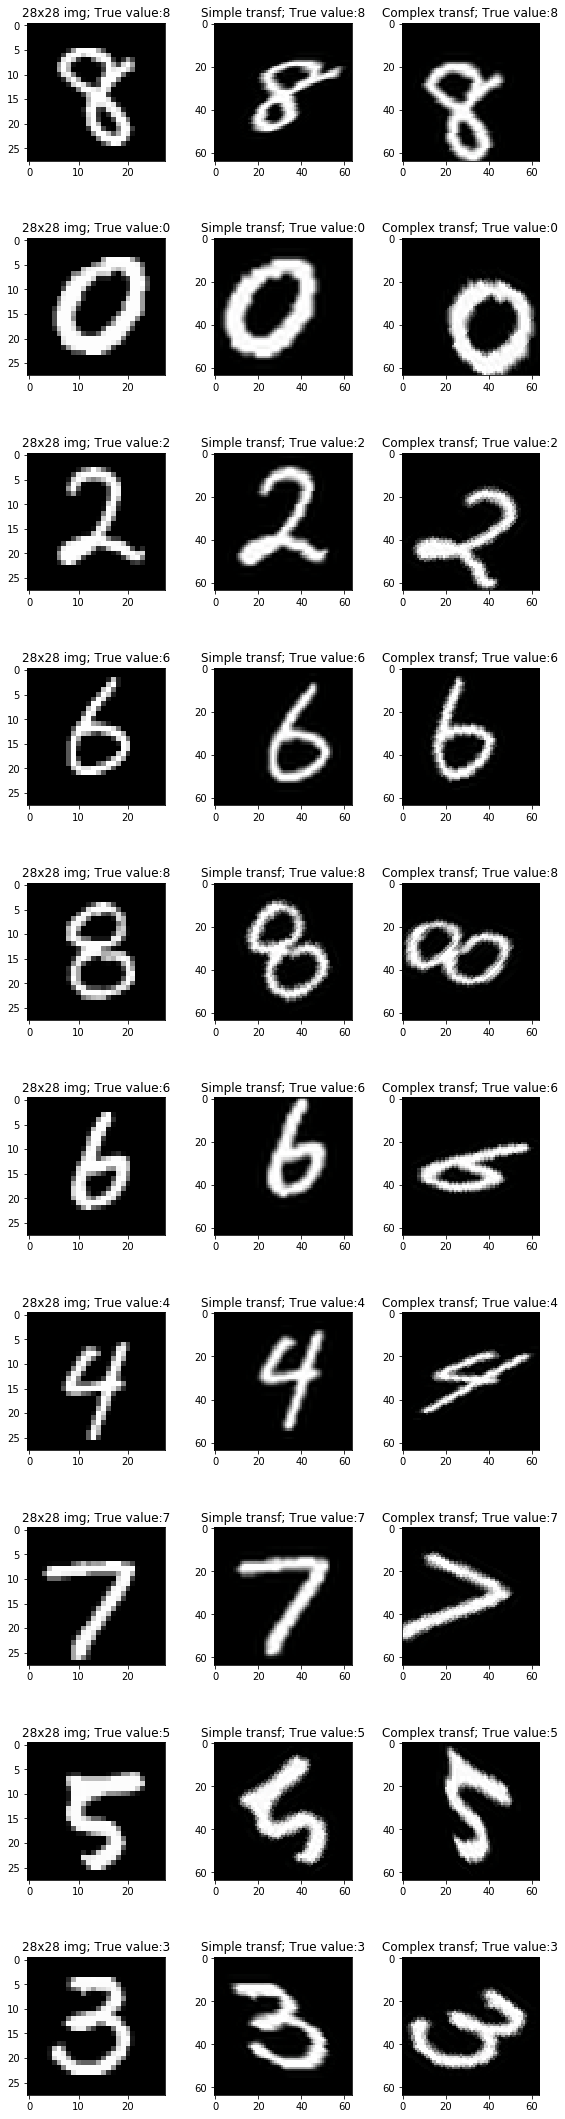

In [13]:
show_transf_effect(10, df_train, df_test, basic_transf, complex_transf, DEVICE, seed = 10)

Definition of transformations for data training parameters for DataBunch class

In [14]:
trms_train = basic_transf
trms_valid_test = transforms.Compose(
    [transforms.ToPILImage(), 
     transforms.Resize(IMAGE_SIZE_AFTER_RESIZE, interpolation=Image.LANCZOS),
     transforms.ToTensor(), 
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
    )

Definition of focal loss function. Model training with focal loss gave worse results than cross entropy loss so cross-entropy loss was used in model training.

In [15]:
class FocalLoss(nn.Module):
    'Calculates focal loss using cross-entropy loss'
    
    def __init__(self, gamma):
        
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')
        
    def forward(self, x, target_y):
        
        # calculate cross-entropy loss for each observation in batch separately
        ce_loss_val = self.ce_loss(x, target_y)
        # restore/calculate (from cross-entropy) predicted probabilities assigned to target_y for each observation in batch
        probs = torch.exp(-ce_loss_val)
        focal_loss_for_obs = (1-probs) ** self.gamma * ce_loss_val
        focal_loss = focal_loss_for_obs.mean()
        
        return focal_loss

Create pretrained model based on res34 architecture

In [16]:
class ConvLearner():
    '''Class defining fit loop used for model training and methods calculating validation statistics.'''

    def __init__(self, data_bunch, model, loss, optim, lr_sched, device, metrics = [accuracy_score]):
        
        self.db = data_bunch
        self.model = model
        self.optim = optim
        self.loss = loss
        self.lr_sched = lr_sched
        self.metrics = metrics
        self.dev = device

    def fit(self, num_epoch, acc_metric_tresh = 0.995, validate_every_pct_obs = 0.05, save_weights = False, output_path=''):
        '''
        Method defining training fit loop. Fit loop runs across batches for selected number of epoch.
        If during training model achives on validation set high accuracy model predictions are saved.
        '''

        self.model.train()
                
        nb_train_obs = len(self.db.ds_train)
        nb_train_batches = np.ceil(nb_train_obs / self.db.dl_train.batch_size)
        
        # Data set in which information above model training are saved.
        train_info_df = pd.DataFrame(columns=['epoch', 'last_batch', 'epoch_pct', 'step_running_train_loss', 'val_loss', 'val_accuracy', 'lr', 'step_train_time'], dtype=np.float64, index=pd.Index([], name="Id", dtype=np.int))
        train_info_df['step_train_time'] = train_info_df['step_train_time'].astype('timedelta64[s]')
        
        # Calculate observation numbers for which validation stats will be calculated 
        obs_nb_for_quantile = np.arange(self.db.dl_train.batch_size, nb_train_obs + 1, self.db.dl_train.batch_size)
        qunantiles = np.arange(validate_every_pct_obs, 1 + validate_every_pct_obs / 3, validate_every_pct_obs )
        obs_nb_to_calc_valid_stats = np.quantile(obs_nb_for_quantile, qunantiles, interpolation='higher')
        
        for epoch in range(num_epoch):
            
            batch_i = 0
            loss_cum = 0. # running loss
            obs = 0 # count observations - number of observation in step (after end of each step validation results are calculated)
            obs_cum = 0 # number of processed observations in current epoch
            
            if self.lr_sched is not None:
                self.lr_sched.step()
                
            str_to_print = f"Learning rate for epoch {epoch+1} is: {self.optim.param_groups[0]['lr']}"
            print(str_to_print)

            start_time = time.time()
            start_time_epoch = start_time
            
            for x, y in self.db.dl_train:

                x_pred = self.model(x)
                output = self.loss(x_pred, y)

                self.optim.zero_grad()
                output.backward()
                self.optim.step()

                with torch.no_grad():

                    loss_cum += output * x.shape[0]
                    batch_i += 1
                    obs += x.shape[0]
                    obs_cum += x.shape[0]

                    if obs_cum in obs_nb_to_calc_valid_stats:

                        train_loss = loss_cum / obs
                        valid_loss, valid_metrics = self.calc_valid_stats()
                    
                        loss_cum = 0.
                        obs = 0
                            
                        # if model is good enough (above treshold) or this is the last epoech save model and its prediction on test set
                        if valid_metrics['accuracy_score'] >= acc_metric_tresh or (epoch + 1 == num_epoch and batch_i == nb_train_batches):
                            
                            acc_str = str(round(valid_metrics["accuracy_score"], 6))
                            
                            if save_weights:

                                checkpoint = {}
                                checkpoint['epoch'] = epoch + 1
                                checkpoint['valid_metric'] = valid_metrics
                                checkpoint['model_state_dict'] = self.model.state_dict()
                                checkpoint['model_optim_dict'] = self.optim.state_dict()
                                checkpoint['model_lr_sched_dict'] = self.lr_sched.state_dict()

                                filename = f'train_checkpoint_epoch_{epoch+1:03}_batch_{batch_i:05}_acc_{acc_str.replace(".", "_")}.pth'
                                filename_with_path = str( output_path / Path(filename) )
                                torch.save(checkpoint, filename_with_path)
                            
                            arr_test_pred = self.predict(self.db.dl_test)
                            df_test_pred = pd.DataFrame(arr_test_pred[0].numpy(), columns = ['Label'], index=pd.Index(list(range(1, arr_test_pred[0].shape[0]+1)), name='ImageId'))
                            
                            filename = f'kaggle_submission_epoch_{epoch+1:03}_batch_{batch_i:05}_acc_{acc_str.replace(".", "_")}.csv'
                            filename_with_path =str( output_path / Path(filename) )
                            df_test_pred.to_csv(filename_with_path)


                        elapsed_time = time.time() - start_time
                        start_time = time.time()
                        
                        str_to_print = f"Ep: {epoch+1:02}, Batch: {batch_i:05} of {nb_train_batches}, loss train: {train_loss:7.5}, valid loss: {valid_loss:7.5}, valid accuracy: {valid_metrics['accuracy_score']:8.6}, time: { str(datetime.timedelta(seconds=round(elapsed_time)))}"
                        print(str_to_print)

                        dict_to_append = {'epoch': epoch + 1, 'last_batch': batch_i, 'step_running_train_loss': train_loss.item(), 
                                          'val_loss': valid_loss.item(), 'val_accuracy': valid_metrics['accuracy_score'], 
                                          'lr': self.optim.param_groups[0]['lr'], 'step_train_time': datetime.timedelta(seconds=round(elapsed_time))}
                        
                        train_info_df = train_info_df.append(dict_to_append, ignore_index=True)
                        
                        if obs_cum == obs_nb_to_calc_valid_stats[-1]:
                            print(f"Epoch {epoch+1:02} train time: { str(datetime.timedelta(seconds=round(time.time() - start_time_epoch)))}")
        
        # save information about training process
        with torch.no_grad():
            
            train_info_df['epoch_pct'] = train_info_df['epoch'] - 1 + train_info_df['last_batch'] / train_info_df['last_batch'].max()
            
            filename = 'training_process.csv'
            filename_with_path = str( output_path / Path(filename) )
                    
            train_info_df.to_csv(filename_with_path)
                
        return None
            
    def calc_valid_stats(self):
        'Calculates loss and metrics on validation data set'
        
        self.model.eval()
        with torch.no_grad():
            
            valid_loss = 0
            nb_of_el = 0
            
            y_pred = []
            y_true = []
            
            for x, y in self.db.dl_valid:
                
                # loss part
                nb_of_el += x.shape[0]
                
                pred_prob = self.model(x)
                valid_loss += self.loss(pred_prob, y) * x.shape[0]
                
                # stats part
                y_true.append(y)
                y_pred.append(pred_prob.argmax(dim = -1))
                
            valid_loss = valid_loss / nb_of_el
            
            y_pred = torch.cat(y_pred).cpu()
            y_true = torch.cat(y_true).cpu()
                
            metr_res = {}
            for metric in self.metrics:
                metr_res[metric.__name__] = metric(y_pred, y_true)
                
            # return average loss and metrics
            return valid_loss, metr_res

    def calc_valid_loss(self):
        '''
        Calculate loss separately for each observation in validaton set. 
        This method is used in selection of observations with highest losses.
        '''
        
        self.model.eval()
        with torch.no_grad():
            
            valid_loss = []
            y_pred = []
            y_true = []
            
            for x, y in self.db.ds_valid:
                
                # add batch dimension to x and y
                x = x[None,:]
                y = y[None]

                pred_prob_one_obs = self.model(x)
                y_one_obs = y
                
                valid_loss.append(self.loss(pred_prob_one_obs, y_one_obs))
                y_true.append(y_one_obs)
                y_pred.append(pred_prob_one_obs.argmax(dim = -1))

            y_pred = torch.cat(y_pred).cpu()
            y_true = torch.tensor(y_true).cpu()
            valid_loss = torch.tensor(valid_loss).cpu()
           
            # return average loss and metrics
            return valid_loss, y_pred, y_true
        
    def predict(self, dl):
        '''
        Predict most probable labels for all observation in data loader and also return true y-s.
        This method is used for model verifiction purpuse.
        '''
        
        self.model.eval()
        with torch.no_grad():
            
            y_pred = []
            y_true = []
            
            for x, y in dl:
                
                y_true.append(y)
                
                pred_prob = self.model(x)
                y_pred.append(pred_prob.argmax(dim = -1))
                
            return torch.cat(y_pred).cpu(), torch.cat(y_true).cpu()

In [17]:
class LastResnetLayers(nn.Module):
    ''' This class is used for modification of last leayer of Resnet-34 model. '''
    
    def __init__(self, in_dim, out_dim):
        super(LastResnetLayers, self).__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        
    def forward(self, x):
        # flatten x (except for batch dimension)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        
        return x

In [33]:
def draw_training_process(df, flt, ax, title):
    '''Function draws training process. '''

    ax.plot(df.loc[flt, 'epoch_pct'], df.loc[flt, 'step_running_train_loss'], label = "Running train loss")
    ax.plot(df.loc[flt, 'epoch_pct'], df.loc[flt, 'val_loss'], label = "Validation loss")

    ax2 = ax.twinx()
    ax2.plot(df.loc[flt, 'epoch_pct'], df.loc[flt, 'val_accuracy'], '-', color = plt.get_cmap("tab10")(2), label = "Validation accuracy")

    ax.set_title(title)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax2.set_ylabel("Accuracy")
    
    ax.legend(loc = 'best')

In [19]:
def draw_confusion_matrix(conv_learner):
    ''' Function draws confusion matrix for validation data set (true labels vs predicted). '''
    
    y_pred, y_true = conv_learner.predict(conv_learner.db.dl_valid)
    
    conf_mat = confusion_matrix(y_true, y_pred)
    conf_mat_df = pd.DataFrame(conf_mat, index=pd.Index(range(0,10), name = 'True'), columns=pd.Index(range(0, 10), name='Pred'))
    
    print("Confusion matrix\n")
    
    nb_correct_pred = np.diag(conf_mat).sum()
    nb_incorrect_pred = int((conf_mat * (np.ones((10,10)) - np.diag(np.repeat(1,10)))).sum())
    
    print("Predictions on validation data set:")
    print("Number of observations in validation data set:", nb_correct_pred + nb_incorrect_pred, "\nNumber of correct predictions:", nb_correct_pred, "\nNumber of incorrect predictions:", nb_incorrect_pred, "\nAccuracy:", nb_correct_pred / conf_mat.sum())
    
    fig, ax = plt.subplots(1,1, figsize=(15,10))
    vmax = np.max(conf_mat * (np.ones((10,10)) - np.diag(np.repeat(1,10))))
    
    pl = sns.heatmap(conf_mat_df, annot=True, ax = ax, cmap=sns.color_palette("Blues"), vmax=vmax)
    display(pl);
    
    return None

In [20]:
def draw_top_losses(conv_learner, nb_of_top_losses, fig_cols = 3):
    '''Draws images with highest losses.'''
    
    valid_loss, y_pred, y_true = conv_learner.calc_valid_loss()
    
    fig_rows = int(np.ceil(nb_of_top_losses / fig_cols))
    
    top_loss, idx = valid_loss.topk(nb_of_top_losses)
    top_y_pred = y_pred[idx]
    top_y_true = y_true[idx]
    
    fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(10,4 * fig_rows))

    for i, ax_i in enumerate(ax.flatten()):
        if i < nb_of_top_losses:
            ax_i.imshow(conv_learner.db.get_image(idx[i], ds_type = 'valid'))
            ax_i.set_title(f"Loss: {top_loss[i]:.3}, True:{top_y_true[i]}, Pred:{top_y_pred[i]}")

# 3. Model training

Create DataBunch object which will be used in model training.

In [21]:
db = DataBunch(df_train, df_test, trms_train, trms_train, DEVICE, dl_batch_size_train = BS_TRAIN, dl_batch_size_valid = BS_VALID)
len(db.idx_train), len(db.idx_valid)

(33600, 8400)

Sizes of training, validation and test sets.

In [22]:
len(db.ds_train), len(db.ds_valid), len(db.ds_test)

(33600, 8400, 28000)

Definition of model used in training. Model uses Resnet-34 architecture. The definition below replaces last two layers of Resnet-34 (average pooling and fully connected) with custom fully connected layer.

In [23]:
res34 = torchvision.models.resnet34(pretrained = True)

# delete last two layers: average pooling and fully connected layers
res34_mod = nn.Sequential(*(list(res34.children())[:-2]))

# calculate input dim to FC layer
one_batch = next(iter(db.dl_train))
with torch.no_grad():
    one_batch_res = res34_mod(one_batch[0].cpu())
    input_dim_to_fc = one_batch_res.view(one_batch_res.shape[0], -1).shape[1]

last_layer = LastResnetLayers(input_dim_to_fc, NB_OF_CLASSES)
res34_mod = nn.Sequential(*(list(res34.children())[:-2]), last_layer)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ubuntu/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 88273282.22it/s]


Move model to computation device and set all weights as learnable (calculate gradients for all weights and biases in the model).

In [24]:
res34_mod = res34_mod.to(DEVICE)

for par in res34_mod.parameters():
    par.requires_grad = True

Set learning parameters.

In [25]:
lr = 4e-4 # Initial learning rate
lr_sched_gamma = 0.6 # Decrease larning rate by this rate after each epoch given in lr_sched_milestones parameter
lr_sched_milestones = list(range(1,20)) # List of epoch after which learning rate is decresed
nb_epoch = 10 # Number of epoches in training process

 Define training objects

In [26]:
model = res34_mod
optim = torch.optim.Adam(model.parameters(), lr = lr)
loss = nn.CrossEntropyLoss(reduction = 'mean')
lr_sched = torch.optim.lr_scheduler.MultiStepLR(optim, lr_sched_milestones, gamma=lr_sched_gamma, last_epoch=-1)

In [27]:
conv_learner = ConvLearner(db, model, loss, optim, lr_sched, DEVICE)

Model training.

In [28]:
conv_learner.fit(nb_epoch, acc_metric_tresh = 0.995, output_path = PATH_OUTPUT)

Learning rate for epoch 1 is: 0.0004
Ep: 01, Batch: 00421 of 8400.0, loss train:  1.6554, valid loss: 0.41523, valid accuracy: 0.869167, time: 0:00:37
Ep: 01, Batch: 00841 of 8400.0, loss train: 0.73824, valid loss: 0.65586, valid accuracy: 0.790833, time: 0:00:35
Ep: 01, Batch: 01261 of 8400.0, loss train: 0.39567, valid loss:  0.4839, valid accuracy: 0.868333, time: 0:00:36
Ep: 01, Batch: 01681 of 8400.0, loss train: 0.36888, valid loss: 0.25379, valid accuracy: 0.929167, time: 0:00:39
Ep: 01, Batch: 02101 of 8400.0, loss train: 0.22808, valid loss: 0.21625, valid accuracy: 0.938571, time: 0:00:40
Ep: 01, Batch: 02521 of 8400.0, loss train: 0.27271, valid loss: 0.20471, valid accuracy:  0.93869, time: 0:00:35
Ep: 01, Batch: 02941 of 8400.0, loss train:  0.2551, valid loss: 0.29339, valid accuracy: 0.915476, time: 0:00:36
Ep: 01, Batch: 03361 of 8400.0, loss train: 0.21421, valid loss: 0.43814, valid accuracy: 0.897143, time: 0:00:36
Ep: 01, Batch: 03781 of 8400.0, loss train: 0.23819

# 4. Training results

In [29]:
training_process = pd.read_csv(PATH_OUTPUT / 'training_process.csv', index_col=0)
training_process.head()

,epoch,last_batch,epoch_pct,step_running_train_loss,val_loss,val_accuracy,lr,step_train_time
0,1.0,421.0,0.050119,1.655440,0.415229,0.869167,0.0004,0 days 00:00:37.000000000
1,1.0,841.0,0.100119,0.738237,0.655863,0.790833,0.0004,0 days 00:00:35.000000000
2,1.0,1261.0,0.150119,0.395675,0.483898,0.868333,0.0004,0 days 00:00:36.000000000
3,1.0,1681.0,0.200119,0.368880,0.253794,0.929167,0.0004,0 days 00:00:39.000000000
4,1.0,2101.0,0.250119,0.228083,0.216245,0.938571,0.0004,0 days 00:00:40.000000000


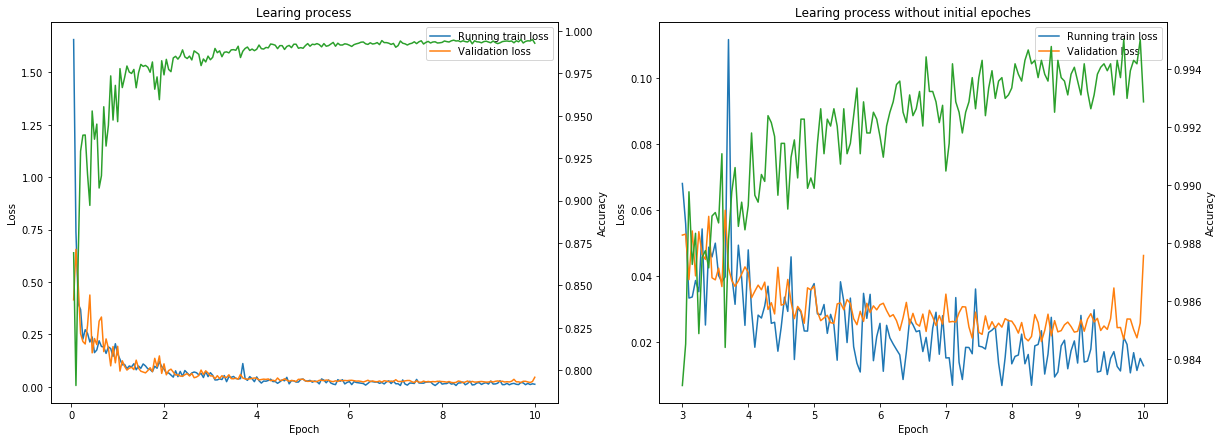

In [35]:
fig, ax = plt.subplots(1,2, figsize=(10 * 2, 7))

flt_1 = training_process['epoch_pct'] >= 0
flt_2 = training_process['epoch_pct'] >= 3

df = training_process

draw_training_process(df, flt_1, ax[0], "Learing process")
draw_training_process(df, flt_2, ax[1], "Learing process without initial epoches")

Confusion matrix

Predictions on validation data set:
Number of observations in validation data set: 8400 
Number of correct predictions: 8352 
Number of incorrect predictions: 48 
Accuracy: 0.9942857142857143


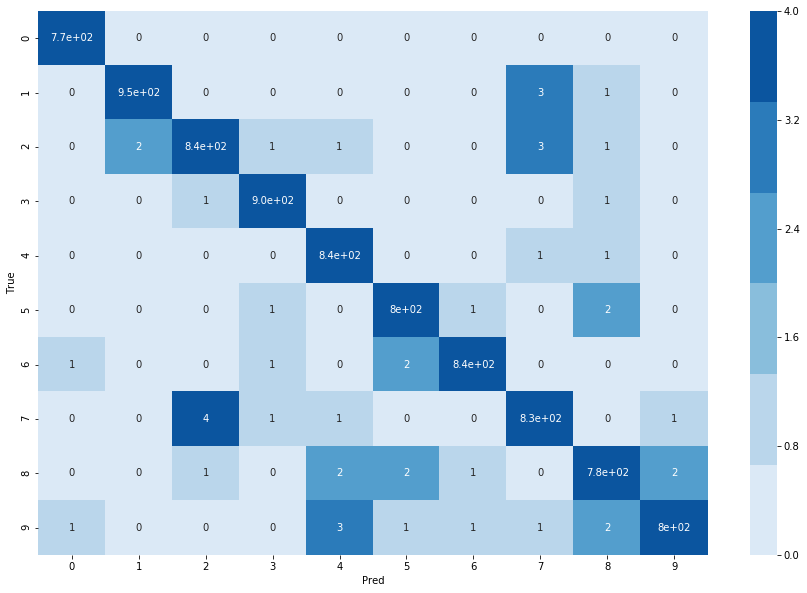

In [31]:
draw_confusion_matrix(conv_learner)

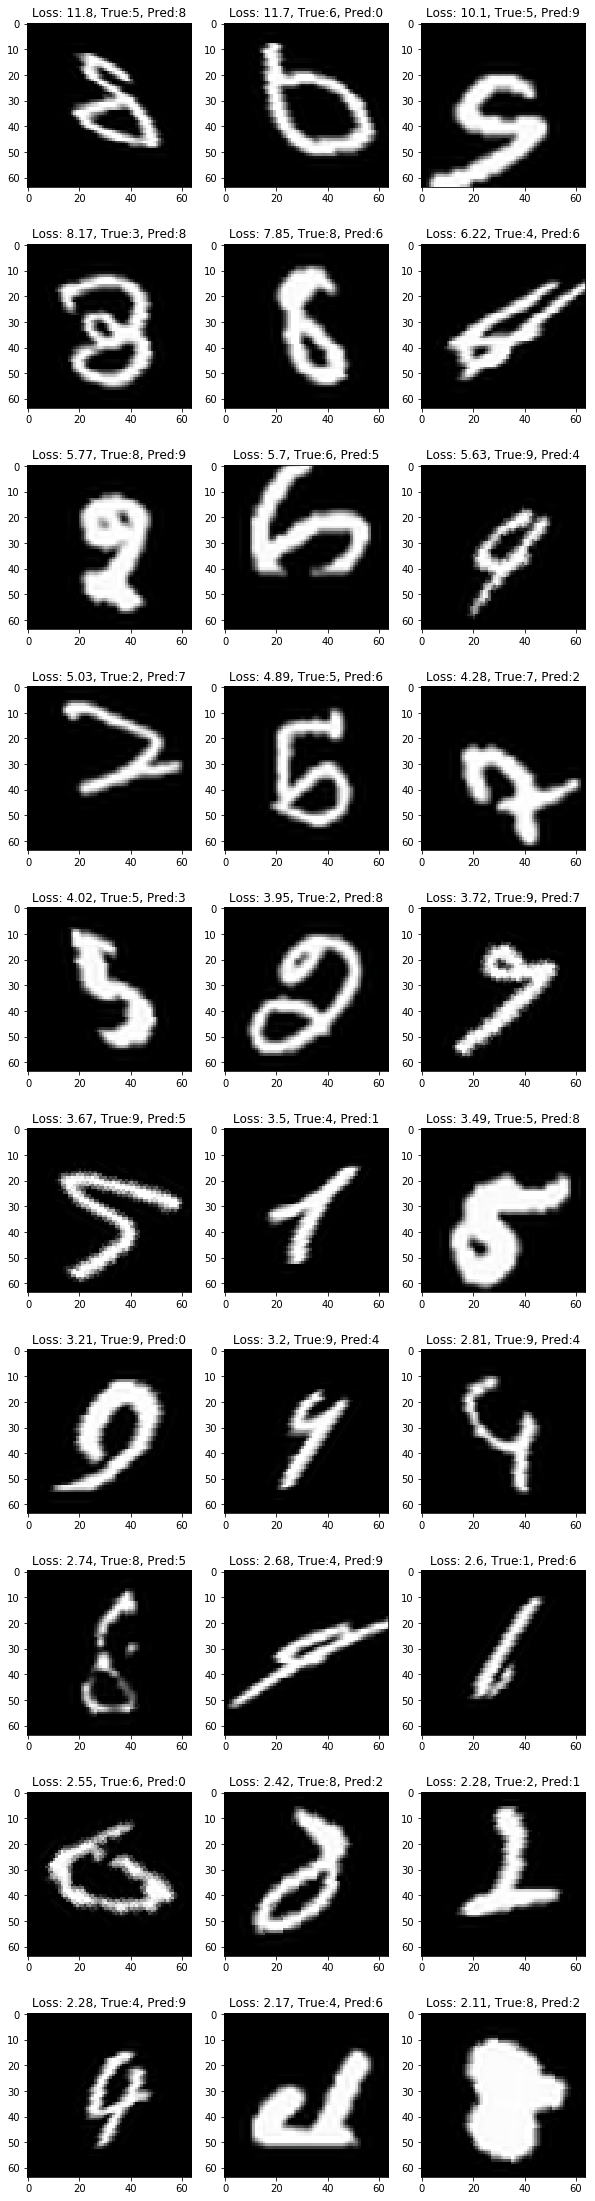

In [32]:
draw_top_losses(conv_learner, nb_of_top_losses = 30)